In [121]:
import sys
sys.path.append("..")
from seaicert.ccsm3_sir_de import SeaIceRT
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import Functions
import xarray as xr
import matplotlib.ticker as mtick

I will load the snow and sea ice measurements from Davis station (Pat data) for 2015

In [55]:
path_data ='../../Davis_Station_2015/'
path_save = '../data/Results/'
save = 0

In [2]:
thickness_data = pd.read_csv(path_data+'/Davis_2015_Zice_Zsnow_Freeboard.csv',parse_dates=['Date'])
thickness_data = thickness_data.drop(columns=['Snow1','Snow2','Snow3','Snow4','Snow5'])
thickness_data['Snow (m)'] = thickness_data['Snow thickness (cm)']/100
thickness_data['Ice thickness (m)'] = thickness_data['Ice thickness (cm)']/100
thickness_data.head()

# An average for each day 
#ddof=0 set to normalize by N instead of N-1 (by default)
thickness_average= thickness_data.groupby(['Date'], as_index=False).agg(
                      {'Snow (m)':['mean',lambda x: np.std(x, ddof=0)],'Ice thickness (m)':['mean',lambda x: np.std(x, ddof=0)]})
thickness_average.columns = ['Date','Mean Snow','Std Snow','Mean Ice','Std Ice']
thickness_average.reindex(columns=sorted(thickness_average.columns))

,Date,Mean Ice,Mean Snow,Std Ice,Std Snow
0,2015-11-19,1.671000,0.383600,0.029900,0.057646
1,2015-11-20,1.606429,0.244571,0.069216,0.114612
2,2015-11-23,1.582917,0.262800,0.046478,0.081683
3,2015-11-29,1.571500,0.249600,0.072251,0.059399
4,2015-12-02,1.583000,0.252300,0.068418,0.072029


In [3]:
# open the ERA5 data
ERA5_data = pd.read_csv(path_data+'/Ta_sst_tcc_ERA5_spatial_interpolated.csv',parse_dates=['Time'],skiprows=[0])
# open pressure level ERA5 data
sp_ERA5_data = pd.read_csv(path_data+'/sp_ERA5_spatial_interpolated.csv',parse_dates=['Time'],skiprows=[0])

In [4]:
date = dt.datetime(2015,11,19,00,00,00)
ERA5_data_subset = ERA5_data[ERA5_data['Time'].between(date,date+dt.timedelta(days=1))].reset_index()
sp_data_subset = sp_ERA5_data[sp_ERA5_data['Time'].between(date,date+dt.timedelta(days=1))].reset_index()

#Cl = ERA5_data_subset['tcc'].mean()
#Ta = ERA5_data_subset['Ta'].mean()

I didn't know exactly where is the point in lat, lon coordinates. But the first point is at 68.5698S; 77.9458E. I will use this for all points

The model only calculates the values for the light hours of each day, which is defined in the number of the day, that could be a decimal number 1.5 is the 1 January at 12:00

In [5]:
# As it's defined the model need 18 vertical parameters, I will use the following pressure levels

pressure= [ 2, 5,10,30,70,100,175,225,350,450,550,600,700,800,875,925,975,1000]

I will now set the input the data from the ERA5 (profiles, and the surface data)

Opening the nc file that contains atmospheric data in pressure levels

In [6]:

forcing_file = path_data+'Atm_profile_Nov_Davis_2015.nc'
#path_save = project.get_repo_path()+'Research/'+station+'_Station/Data/'+str(year)+'_simulations/Comparison_ESIM_data/Sim'+str(sim)
with xr.open_dataset(forcing_file) as ds:
    print(ds.keys())
lat_point = -68.568904
lon_point = 77.945439

KeysView(<xarray.Dataset>
Dimensions:    (longitude: 5, latitude: 5, level: 37, time: 96)
Coordinates:
  * longitude  (longitude) float32 77.0 77.25 77.5 77.75 78.0
  * latitude   (latitude) float32 -68.0 -68.25 -68.5 -68.75 -69.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2015-11-19 ... 2015-11-29T23:00:00
Data variables:
    cc         (time, level, latitude, longitude) float32 ...
    o3         (time, level, latitude, longitude) float32 ...
    clwc       (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
    crwc       (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-30 08:36:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...)


In [7]:
print('The variables from the nc file are ',list(ds.keys()))

The variables from the nc file are  ['cc', 'o3', 'clwc', 'q', 'crwc', 't']


The variables are:

- cc: cloud cover (fraction)
- o3: Ozone mass mixing ratio (kg/kg)
- clwc: Specific cloud liquid water content (kg/kg)
- q: specific_humidity (kg/kg), is the mass of water vapour per kilogram of moist air. The total mass of moist air is the sum of the dry air, water vapour, cloud liquid, cloud ice, rain and falling snow.
- crwc: Specific rain water content (kg/kg)
- t: air_temperature (K)

 And for the forcing Delta Eddington I need:

- Level = numbers
- pressure = pressure
- air_temperature = t
- water_vapor_mixing_ratio = specific humidity
- ozone_mixing_ratio = O3
- cloud_cover = cc
- cloud_liquid_water_path = ? 

From ERA5 single level 

- surface_pressure = 1008.0
- co2_volume_mixing_ratio = 0.00037
- surface_air_temperature = 273.16
- ground_temperature = 273.16

In [8]:
# selecting variables
variables_all = list(ds.keys())
index_var_selected = [0,1,2,3,4,5]
variables = [variables_all[i] for i in index_var_selected]
variables_names = list(ds.keys()) # using the same name from the file
columns_name = ['Time']+variables_names
interpolated_data_clean = pd.DataFrame(columns=columns_name)
interpolated_data_clean['Time'] = ds.coords['time'].data
print([(var,name) for (var,name) in zip(variables,variables_names)])

[('cc', 'cc'), ('o3', 'o3'), ('clwc', 'clwc'), ('q', 'q'), ('crwc', 'crwc'), ('t', 't')]


I need this values for the date 

- Level = numbers
- pressure = pressure
- air_temperature = t
- water_vapor_mixing_ratio = specific humidity
- ozone_mixing_ratio = O3
- cloud_cover = cc
- cloud_liquid_water_path = ? 

In [9]:
# Now I will the spatial interpolation for each variable, and I will repeat for each level
atm_data_ERA5 =  dict.fromkeys(pressure)
for level in pressure:
    print('level:',level)
    interpolated_data=interpolated_data_clean
    for variable,var_name in zip(variables,variables_names):
        interpolated_data[var_name] =Functions.spatial_interpolation (ds=ds,variable=variable,lat_point=lat_point,lon_point=lon_point,lon_name='longitude',lat_name='latitude',level=level)
    atm_data_ERA5[level] = interpolated_data.copy()

level: 2
level: 5
level: 10
level: 30
level: 70
level: 100
level: 175
level: 225
level: 350
level: 450
level: 550
level: 600
level: 700
level: 800
level: 875
level: 925
level: 975
level: 1000


I will do a few of testing. I don't have a data from ERA5 for the cloud_liquid_water_path and I think it is in relation with the Cl ( in the example model only put 1 element in the vertical profile). I will do firstly testing different arbitrary values like 0, 0.5 and 1, in all the cases with the corresponding cloud_liquid_water_path = 60  as in the default

In [156]:
# runing the model
# testing different Cl and clwp
Cls = [0,0.5,1]
Cls_results = dict.fromkeys(Cls)
model = SeaIceRT()
model.latitude = -68.568904
clwp = 120
for Cl in Cls:
    results = []
    sw_absorbed_by_ocean = []
    surface_dw_sw_direct_diffuse_flux = []
    
    for I,i in enumerate(np.arange(1,2,1/24)):
        
        # getting the  profile for the corresponding date
        date_H = date +dt.timedelta(days=i)
        #print(date_H)
        
        DE_input_profiles = pd.DataFrame(columns=['levels','pressure','air_temperature','water_vapor_mixing_ratio','ozono_mixing_ratio','cloud_cover'])
        ERA5_names = ['t','q','o3','cc']    
        DE_names = ['air_temperature','water_vapor_mixing_ratio','ozono_mixing_ratio','cloud_cover']
        for ERA_name, DE_name, in zip(ERA5_names,DE_names):
            DE_input_profiles[DE_name] = Functions.atm_profile(file=atm_data_ERA5,variable = ERA_name,date=date_H,levels=pressure)
        DE_input_profiles['levels'] = np.arange(len(pressure),0,-1,dtype=float)
        DE_input_profiles['pressure'] =pressure
        
        # to the surface values
        # converting the surface pressure from the Pa to hPa
        DE_input_surf = pd.DataFrame({'surface_pressure':sp_ERA5_data[sp_ERA5_data.Time==date]['sp'].copy()/100,
                                'co2_volume_mixing_ratio':0.00037,
                                'surface_air_temperature':ERA5_data[ERA5_data.Time==date]['Ta'].copy(),
                                'ground_temperature':ERA5_data[ERA5_data.Time==date]['Ta'].copy()
                                })
        
        
        model.day_of_year = date.timetuple().tm_yday + date_H.timetuple().tm_hour/24    
        model.pressure = pressure
        model.air_temperature = DE_input_profiles['air_temperature'].values
        model.water_vapor_mixing_ratio = DE_input_profiles['water_vapor_mixing_ratio'].values
        model.ozone_mixing_ratio = DE_input_profiles['ozono_mixing_ratio'].values
        model.surface_pressure = DE_input_surf['surface_pressure'].values[0]
        model.surface_air_temperature = DE_input_surf['surface_air_temperature'].values[0]
        model.ground_temperature = DE_input_surf['ground_temperature'].values[0]
        model.snow_depth = thickness_average[thickness_average.Date== date]['Mean Snow'].values[0]
        model.pond_depth = 0.0
        model.sea_ice_thickness = thickness_average[thickness_average.Date== date]['Mean Ice'].values[0]
        model.cloud_cover = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, Cl, 0.0, 0.0]
        model.cloud_liquid_water_path = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, clwp, 0.0, 0.0]
        model.run()
        output = model.get_results()
        sw_absorbed_by_ocean.append(output["downwelling_shortwave_flux_absorbed_by_ocean"])
        surface_dw_sw_direct_diffuse_flux. append(output["surface_downwelling_direct_shortwave_flux"]+output["surface_downwelling_direct_shortwave_flux"])
    Cls_results[Cl]= pd.DataFrame({'Time':pd.date_range(start=date,periods=len(sw_absorbed_by_ocean),freq='1H'),'downwelling_shortwave_flux_absorbed_by_ocean':sw_absorbed_by_ocean,'surface_dw_sw_direct_diffuse_flux':surface_dw_sw_direct_diffuse_flux})
    print('Cl:',Cl,'loud_liquid_water_path:',clwp)

Cl: 0 loud_liquid_water_path: 120
Cl: 0.5 loud_liquid_water_path: 120
Cl: 1 loud_liquid_water_path: 120


In [80]:
df_results_Cl_1= pd.DataFrame({'Time':pd.date_range(start=date,periods=len(sw_absorbed_by_ocean),freq='1H'),'downwelling_shortwave_flux_absorbed_by_ocean':sw_absorbed_by_ocean,'surface_dw_sw_direct_diffuse_flux':surface_dw_sw_direct_diffuse_flux})

In [101]:
save = 1

The plot was saved


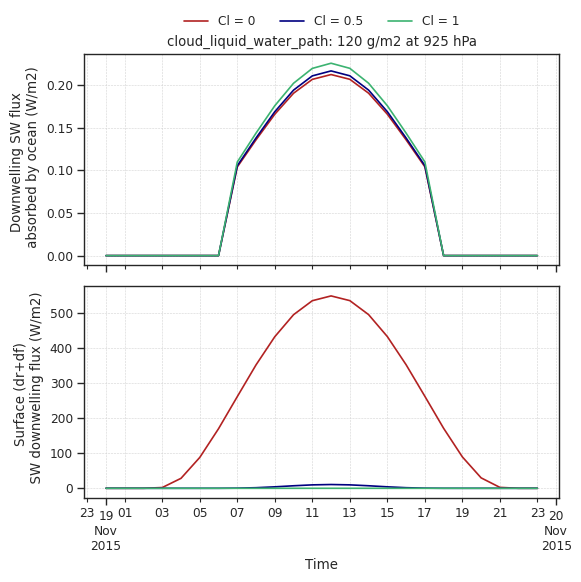

In [104]:
# Plotting 

colors = sns.color_palette()
colors = ['firebrick','navy','mediumseagreen','orchid','gold']
cm = 1/2.54  # centimeters in inches
sns.set_context('paper')
sns.set_style("ticks")
f, axs = plt.subplots(2, 1,figsize=(15*cm, 15*cm),sharex=True)
ax0 = axs[0]
ax1 = axs[1]
for i,Cl in enumerate(Cls):
    sns.lineplot(x='Time',y='downwelling_shortwave_flux_absorbed_by_ocean',data=Cls_results[Cl],ax=ax0,label = 'Cl = '+ str(Cl),color=colors[i])
    sns.lineplot(x='Time',y='surface_dw_sw_direct_diffuse_flux',data=Cls_results[Cl],ax=ax1,color=colors[i])



ax0.set_title('cloud_liquid_water_path: '+str(clwp)+' g/m2 at 925 hPa')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax0.set_ylabel('Downwelling SW flux \n absorbed by ocean (W/m2)')
ax1.set_ylabel('Surface (dr+df) \n  SW downwelling flux (W/m2)')


ax0.grid(color='lightgray',which='both',linestyle='--',linewidth=0.4)
ax1.grid(color='lightgray',which='both',linestyle='--',linewidth=0.4)

sns.move_legend(ax0, "lower center",bbox_to_anchor=(.5, 1.07),ncol=3,title=None,frameon=False)
f.tight_layout()


if save ==1:        
    save_name = 'Light_testing_Cl_clwp_'+str(clwp)+'_'+date.strftime("%b_%d_%Y")+'.tiff'
    f.savefig(path_save + save_name, bbox_inches='tight', dpi = 300)
    print('The plot was saved')
#     plt.close()

In [163]:
model = SeaIceRT()
model.print_parameters()

day_of_year = 140.477
latitude = 80.0
level = [18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0]
pressure = [2.0, 5.0, 15.0, 35.0, 60.0, 105.0, 160.0, 235.0, 320.0, 420.0, 520.0, 610.0, 710.0, 800.0, 870.0, 930.0, 970.0, 1000.0]
air_temperature = [273.0, 251.0, 234.0, 226.0, 225.0, 225.0, 225.0, 225.0, 234.0, 247.0, 257.0, 265.0, 272.0, 277.0, 280.0, 281.0, 278.0, 276.0]
water_vapor_mixing_ratio = [4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 6.4e-06, 2.6e-05, 0.00012, 0.00052, 0.0011, 0.002, 0.0031, 0.0042, 0.0051, 0.0059, 0.004, 0.003]
ozone_mixing_ratio = [7e-06, 1.3e-05, 1e-05, 5.5e-06, 4.2e-06, 2.2e-06, 1e-06, 5e-07, 2e-07, 1.4e-07, 1e-07, 8e-08, 7e-08, 6e-08, 5.5e-08, 5e-08, 4.5e-08, 4e-08]
cloud_cover = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
cloud_liquid_water_path = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 0.0, 0.0]
surface_pressure = 1008.0

In [174]:
# defaul parameters
atm_data_defautl_DE = pd.DataFrame({'level':[18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0],
                                    'pressure': [2.0, 5.0, 15.0, 35.0, 60.0, 105.0, 160.0, 235.0, 320.0, 420.0, 520.0, 610.0, 710.0, 800.0, 870.0, 930.0, 970.0, 1000.0],
                                    'air_temperature':[273.0, 251.0, 234.0, 226.0, 225.0, 225.0, 225.0, 225.0, 234.0, 247.0, 257.0, 265.0, 272.0, 277.0, 280.0, 281.0, 278.0, 276.0],
                                    'water_vapor_mixing_ratio':[4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 6.4e-06, 2.6e-05, 0.00012, 0.00052, 0.0011, 0.002, 0.0031, 0.0042, 0.0051, 0.0059, 0.004, 0.003],
                                    'ozono_mixing_ratio':[7e-06, 1.3e-05, 1e-05, 5.5e-06, 4.2e-06, 2.2e-06, 1e-06, 5e-07, 2e-07, 1.4e-07, 1e-07, 8e-08, 7e-08, 6e-08, 5.5e-08, 5e-08, 4.5e-08, 4e-08],
                                    'cloud_cover':[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                                    'cloud_liquid_water_path':[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 0.0, 0.0]
                                   })

In [178]:
save = 1

The plot was saved


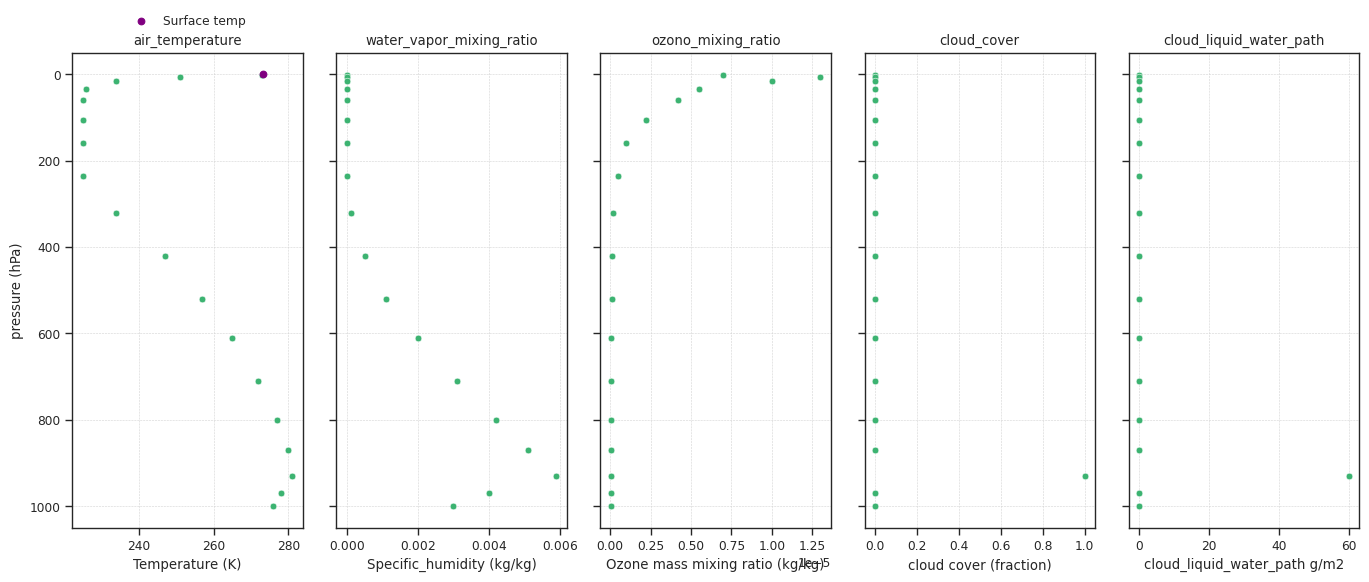

In [179]:
# Plotting vertical profiles
DE_input_profiles

sns.set_context('paper')
sns.set_style("ticks")
f, axs = plt.subplots(1, 5,figsize=(35*cm, 15*cm),sharey=True)
ax0 = axs[0]
ax1 = axs[1]
ax2 = axs[2]
ax3 = axs[3]
ax4 = axs[4]


variables = ['air_temperature',	'water_vapor_mixing_ratio',	'ozono_mixing_ratio','cloud_cover','cloud_liquid_water_path']

for variable,ax in zip(variables,axs.flatten()):
#    sns.scatterplot(x=variable,y='pressure',data=DE_input_profiles,ax=ax,color=colors[1])
    sns.scatterplot(x=variable,y='pressure',data=atm_data_defautl_DE,ax=ax,color=colors[2])
    ax.grid(color='lightgray',which='both',linestyle='--',linewidth=0.4)
    ax.set_title(variable)
    
#ax0.scatter(DE_input_surf['surface_air_temperature'].values[0],0,color='purple')
ax0.scatter(273.16,0,color='purple',label='Surface temp')
ax0.legend()
sns.move_legend(ax0, "lower center",bbox_to_anchor=(.5, 1.03), ncol=1,title=None,frameon=False)


ax0.invert_yaxis()
ax0.set_ylabel('pressure (hPa)')
ax0.set_xlabel('Temperature (K)')
ax1.set_xlabel('Specific_humidity (kg/kg)')
ax2.set_xlabel('Ozone mass mixing ratio (kg/kg)')
ax3.set_xlabel('cloud cover (fraction)')
ax4.set_xlabel('cloud_liquid_water_path g/m2')

ax1.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))

# I will do lines with the surface values




#ax0.set_title('cloud_liquid_water_path: '+str(clwp)+' g/m2 at 925 hPa')
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
#ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
#ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
#ax1.xaxis.set_major_locator(mdates.DayLocator())
#ax0.set_ylabel('Downwelling SW flux \n absorbed by ocean (W/m2)')
#ax1.set_ylabel('Surface (dr+df) \n  SW downwelling flux (W/m2)')


ax0.grid(color='lightgray',which='both',linestyle='--',linewidth=0.4)
#ax1.grid(color='lightgray',which='both',linestyle='--',linewidth=0.4)

#sns.move_legend(ax0, "lower center",bbox_to_anchor=(.5, 1.07),ncol=3,title=None,frameon=False)
f.tight_layout()


if save ==1:        
    save_name = 'Atm_profile_default_parameters.tiff'
    f.savefig(path_save + save_name, bbox_inches='tight', dpi = 300)
    print('The plot was saved')
    #plt.close()

I will plot the default value parameters for the atmospheric profile

In [ ]:
# Plotting vertical profiles
DE_input_profiles

sns.set_context('paper')
sns.set_style("ticks")
f, axs = plt.subplots(1, 4,figsize=(30*cm, 15*cm),sharey=True)
ax0 = axs[0]
ax1 = axs[1]
ax2 = axs[2]
ax3 = axs[3]

variables = ['air_temperature',	'water_vapor_mixing_radio',	'ozono_mixing_radio','cloud_cover']

for variable,ax in zip(variables,axs.flatten()):
    sns.scatterplot(x=variable,y='pressure',data=DE_input_profiles,ax=ax)
    ax.grid(color='lightgray',which='both',linestyle='--',linewidth=0.4)
    ax.set_title(variable)
    
ax0.scatter(DE_input_surf['surface_air_temperature'].values[0],0,color='purple')

ax0.invert_yaxis()
ax0.set_ylabel('pressure (hPa)')
ax0.set_xlabel('Temperature (K)')
ax1.set_xlabel('Specific_humidity (kg/kg)')
ax2.set_xlabel('Ozone mass mixing ratio (kg/kg)')
ax3.set_xlabel('cloud cover (fraction)')
ax1.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))

# I will do lines with the surface values




#ax0.set_title('cloud_liquid_water_path: '+str(clwp)+' g/m2 at 925 hPa')
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b\n%Y'))
#ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
#ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
#ax1.xaxis.set_major_locator(mdates.DayLocator())
#ax0.set_ylabel('Downwelling SW flux \n absorbed by ocean (W/m2)')
#ax1.set_ylabel('Surface (dr+df) \n  SW downwelling flux (W/m2)')


ax0.grid(color='lightgray',which='both',linestyle='--',linewidth=0.4)
#ax1.grid(color='lightgray',which='both',linestyle='--',linewidth=0.4)

#sns.move_legend(ax0, "lower center",bbox_to_anchor=(.5, 1.07),ncol=3,title=None,frameon=False)
f.tight_layout()


#if save ==1:        
#    save_name = 'Light_testing_Cl_clwp_'+str(clwp)+'_'+date.strftime("%b_%d_%Y")+'.tiff'
#    f.savefig(path_save + save_name, bbox_inches='tight', dpi = 300)
#    print('The plot was saved')
#     plt.close()

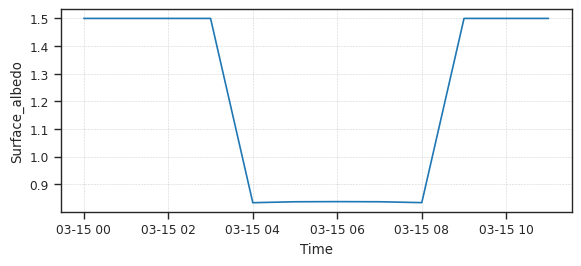

In [30]:
# Plotting 

colors = sns.color_palette()
colors = ['firebrick','navy','mediumseagreen','orchid','gold']
cm = 1/2.54  # centimeters in inches
sns.set_context('paper')
sns.set_style("ticks")
f, axs = plt.subplots(1, 1,figsize=(15*cm, 7*cm))
ax0 = axs

sns.lineplot(x='Time',y='Surface_albedo',data=df_results,ax=ax0)
#ax0.xaxis.set_minor_locator(mdates.MonthLocator())
#ax0.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
#ax0.xaxis.set_major_locator(mdates.YearLocator())
#ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax0.grid(color='lightgray',which='both',linestyle='--',linewidth=0.4)
f.tight_layout()